In [2]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
from datetime import datetime as dt
from folium import FeatureGroup
import flood_tool
import folium
import matplotlib as matplotlib

In [3]:
# read and clean the station related data
wet = pd.read_csv('./flood_tool/resources/wet_day.csv'); 
refLoc = pd.read_csv('./flood_tool/resources/stations.csv'); 
typ = pd.read_csv('./flood_tool/resources/typical_day.csv')

wet.loc['dateTime'] = pd.to_datetime(wet.dateTime)
wet = wet.dropna()

for i in wet.index.values:
    if '|' in wet.loc[i].value:
        wet.loc[i].value = wet.loc[i].value[:2]
wet.value = wet.value.astype(np.float64)


wet_rain = wet[(wet.qualifier=='Tipping Bucket Raingauge')& (wet.value<20)].groupby('stationReference')[['value']].mean()
wet_river = wet[(wet.qualifier=='Stage') & (wet.value<200)].groupby('stationReference')[['value']].mean()
wet_tide = wet[(wet.qualifier=='Tidal Level') & (wet.value<200)].groupby('stationReference')[['value']].mean()

typ.loc['dateTime'] = pd.to_datetime(typ.dateTime)
typ = typ.dropna()

typ_rain = typ[(typ.qualifier=='Tipping Bucket Raingauge')& (typ.value<20)].groupby('stationReference')[['value']].mean()
typ_river = typ[(typ.qualifier=='Stage') & (typ.value<200)].groupby('stationReference')[['value']].mean()
typ_tide = typ[(typ.qualifier=='Tidal Level') & (typ.value<200)].groupby('stationReference')[['value']].mean()

In [4]:
# find the location for each station (if we have)
reflatlon = {'lat':{},'lon':{}}
for i in range(len(refLoc)):
    reflatlon['lat'][refLoc.stationReference[i]] = refLoc.latitude[i]
    reflatlon['lon'][refLoc.stationReference[i]] = refLoc.longitude[i]
    
ele = {'typ_rain':typ_rain,'typ_river':typ_river,'typ_tide':typ_tide,'wet_rain':wet_rain,
       'wet_river':wet_river,'wet_tide':wet_tide}

for key,df in ele.items():
    df['lat']=df.index.map(reflatlon['lat']).values
    df['lon']=df.index.map(reflatlon['lon']).values
    ele[key] = df.dropna()

In [5]:
def cmap2color(maptype,levels):
    '''Get the colors in hex based on the cmap type.
    
    Parameters
        ----------

        maptype: str
            Name of cmap.
            
        levels: int
            Number of colors which is equally spaced on the cmap colors 
        
        Returns
        -------
        
        list
            list of hex indexs of the colors
      
        '''    
    colors = []
    # Get cmap
    cmap = matplotlib.cm.get_cmap(maptype, levels)   
    # From rgb to hex
    for i in range(cmap.N):
        rgba = cmap(i)
        colors.append(matplotlib.colors.rgb2hex(rgba))
    return(colors)

In [6]:
def addlayer(lat,lon,value,name,levels,cmtype):
    '''Create a folium.GeoJson instance for further plotting. The instance try to plot contourf on a folium map.
    
    Parameters
    ----------

    lat,lon: sequence of floats
        Location of the value that you'd like to plot.

    levels: int
        Number of levels of contourf 
        
    name: str
        The name of the value
        
    cmtype: str
        The name of the cmap used in the contourf
        
    Returns
    -------

    layer
        a folium.GeoJson instance as a contourf
        
    cm_
        a branca.colormap.LinearColormap instance as the colorbar
    
    References
    ----------
    Inspired by: https://www.tjansson.dk/2018/10/contour-map-in-folium/
    '''
    
    mean = value.mean()
    std  = value.std()
    colors = cmap2color(cmtype,levels)
    if name=='class':
        vmin   = value.min()
        vmax   = value.max()
    elif (name == 'risk') or ('rice' in name) or('rain' in name) or ('value' in name):
        vmin   = value.min()
        vmax   = mean + 2 * std        
    else:
        vmin   = mean - 2 * std
        vmax   = mean + 2 * std
    levels = len(colors)
    cm_     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels) 
    cm_.caption = name

    df = pd.DataFrame({
        'longitude':  lon,
        'latitude':   lat,
        'value': value} )

    # The original data
    x_orig = np.asarray(df.longitude.tolist())
    y_orig = np.asarray(df.latitude.tolist())
    z_orig = np.asarray(df.value.tolist())

    # Make a grid
    x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
    y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
    x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

    # Grid the values
    z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')

    # Gaussian filter the grid to make it smoother
    if 'tid' in name:
        sigma = [15, 15]
    else:
        sigma = [5, 5]
    z_mesh = sp.ndimage.gaussian_filter(z_mesh, sigma, mode='constant')

    # Create the contour
    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax);
    
    geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5);
    
    layer = folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    },name=name)
    
    return layer,cm_

In [68]:
cmdefault = {'typ_rain':'Greens','typ_river':'YlOrBr','typ_tide':'Greys','wet_rain':'Reds',
       'wet_river':'Blues','wet_tide':'Purples'}

levelsdefault = {'typ_rain':6,'typ_river':6,'typ_tide':6,'wet_rain':6,
       'wet_river':6,'wet_tide':6}

ploted = ['typ_rain', 'typ_river','typ_tide','wet_rain','wet_river','wet_tide','class','medianPrice','impact','risk','total_value','live_rain']

def plotonmap(toplot=ploted,data=ele,avoidrun=1, cmtypes= cmdefault, levels=levelsdefault ,tile='cartodbpositron',meteoEle = [], marker=True):
    '''Plot the contourf based on the folium package.
    
    Parameters
    ----------
    toplot: list of str
        The elements you would like to plot. Default to all the element you can plot, including the data for a typical day, a wet         day, station live rain, and all the outputs of the models.      (['typ_rain','typ_river','typ_tide','wet_rain','wet_river','wet_tide','class','medianPrice','impact','risk','total_value','live_rain'])
        
    data: dictionary
        With key the name of the target to plot and the value a pd.Dataframe including columns named lat, lon and
        value. Default to be a dic of len 6, corresponding to the data of a typical day and wet day, each have three 
        kinds of measurement(river, tide and rain). 
        
    avoidrun: int
        Do not change this, or the function could raise an error

    cmtype: dic
        Please ensure the dictionary include all the keys in dic data, with the value of the key a str that you'd like
        to use to plot the key, support all kinds of pyplot cmap.
        
    levels: dir
        Please ensure the dictionary include all the keys in dic data, with the value of the key a number that you'd like
        to set contourf level.
    
    tile: str
        Type of tile to generate the base map. default to 'cartodbpositron'. 
        
    meteoEle: list of str
        List of extra meteorological information which wil be ploted. Default to none. Support 'temperature', 'dewPoint','humidity','windSpeed','windDirection','windGust','pressureSeaLevel','precipitationIntensity','visibility','cloudBase','cloudCeiling','particulateMatter25','pollutantNO2','pollutantCO','fireIndex','floodIndex','soilMoistureVolumetric40To100'. 
    
    marker: bool
        If true, then will mark the at risk station according to the offline typical day and wet day data. If False, will not plot the marker. Default to True.
        
    Returns
    -------
        geomap: folium map
       '''
    API_KEY = '758331efe8e44d18a78e8a61a30ff2bf'
    
    # Set up the folium plot
    geomap = folium.Map([52, -1.2], zoom_start=7, tiles=tile,control_scale=True);
    folium.TileLayer('Stamen Terrain').add_to(geomap)
    folium.TileLayer('Stamen Toner').add_to(geomap)
    folium.TileLayer(tiles='https://{s}.tile.thunderforest.com/pioneer/{z}/{x}/{y}.png?apikey=' +
        API_KEY, name='thunderforestpioneer',attr='na').add_to(geomap)
    folium.TileLayer(tiles='http://tile.stamen.com/watercolor/{z}/{x}/{y}.jpg',attr='na',name='stamenwater',overlay=True, opacity=0.6).add_to(geomap)
    folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='na',name='EsriWorld').add_to(geomap)

    time = dt.now().isoformat(timespec='milliseconds')+'Z'
    meteo=['temperature', 'dewPoint','humidity','windSpeed','windDirection','windGust','pressureSeaLevel','precipitationIntensity','visibility','cloudBase','cloudCeiling',
          'particulateMatter25','pollutantNO2','pollutantCO','fireIndex','floodIndex','soilMoistureVolumetric40To100']
    for i in meteoEle:
        if i not in meteo:
            print(f'wrong meteoele input {i}')
            meteoEle.remove(i)
            
    for i in range(len(meteoEle)):
        folium.TileLayer(name=meteoEle[i],tiles= 
              'https://api.tomorrow.io/v4/map/tile/{z}/{x}/{y}/'+f'{meteoEle[i]}/{time}.png?apikey=rb0ZKOGPoCC2jWswc6y4UOWR3jTQzUlQ',attr='1',overlay=True,opacity=0.8,show=False).add_to(geomap)

    for key,df in data.items():
        if key in toplot:
            layer,cm_ = addlayer(df.lat,df.lon,df.value,key,levels[key],cmtypes[key])
            feature_group = FeatureGroup(name=key,show=False)
            feature_group.add_child(layer)
            geomap.add_child(feature_group)
            if 'rain' in key:
                cm_.caption = key+'(mm/15min (averaged))'
            elif 'tide' in key:
                cm_.caption = key+'(mAOD)'
            elif 'river' in key:
                cm_.caption = key+'(mASD)'
            elif ('rice' in key) or ('risk' in key):
                cm_.caption = key+'(£)'
                
            geomap.add_child(cm_)
            
    if marker:
        feature_group = FeatureGroup(name='marked_abnormal',show=False)
        for i in range(len(risk)):
            folium.Marker([risk.lat[i], risk.lon[i]], popup='station:'+risk.index[i]+f'; river_level:{risk.value[i]}; impact:{risk.impact[i]}').add_to(feature_group)
    geomap.add_child(feature_group)
    
    # Add the colormap to the folium map
    folium.LayerControl().add_to(geomap)     
    
    
    # Fullscreen mode
    plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap);
    geomap.add_child(folium.LatLngPopup())
    
    
    return geomap;

In [8]:
# Read the two dangerous location according to the offline two days data. The decision is made in indicate_area_at_risk.ipynb
impact = pd.read_csv('impact.csv')
impact['lon']=impact['long']
impact = impact.drop(columns='long')
risk = pd.concat([wet_river.loc['2660'],wet_river.loc['2830']],axis=1).T
risk['impact']=np.array([2200154,4590502])

In [10]:
# Build a integrated dataframe for all the model result, using all the unlabeld postcode.
# NB. If you have already sabe your model resuilt somewhere, just read it directlt, do not do the prediction again
# cost you time.
unlabeled = pd.read_csv('./flood_tool/resources/postcodes_unlabelled.csv')
pt = unlabeled.postcode
too = flood_tool.tool.Tool()
df = too.get_lat_long(pt)
df = df.drop_duplicates()
too.train()

In [11]:
df['class'] = too.get_flood_class_from_postcodes(df.index).values
df['medianPrice'] = too.get_median_house_price_estimate(df.index).values
df['risk'] = too.get_annual_flood_risk(df.index).values
df['total_value'] = too.get_total_value(df.index).values

In [ ]:
# Grab live rain data from online
live_rain = wet_rain.copy().dropna()
error = 0
for i in range(len(live_rain)):
    try:
        live_rain.value[i] = flood_tool.live.get_live_station_data(live_rain.index.values[i])
    except Exception:
        error += 1
        pass
print(f'live rain stations no data: {error}')

In [77]:
# Convert to what the plot function can accept
elenew = ele.copy()


df['value'] = df.medianPrice.copy()
elenew['medianPrice'] = df.copy()

df['value'] = df['class'].copy()
elenew['class'] = df.copy()

df['value'] = df['risk'].copy()
elenew['risk'] = df.copy()

df['value'] = df['total_value'].copy()
elenew['total_value'] = df.copy()

elenew['live_rain'] = live_rain

cmnew = cmdefault.copy()
cmnew['medianPrice'] = 'viridis'
cmnew['class'] = 'magma'
cmnew['risk'] = 'cividis'
cmnew['total_value'] = 'plasma'
cmnew['live_rain'] = 'Blues'

levelsnew = levelsdefault.copy()
levelsnew['medianPrice'] = 6
levelsnew['class'] = 10
levelsnew['risk'] = 6
levelsnew['total_value'] = 6
levelsnew['live_rain'] = 6

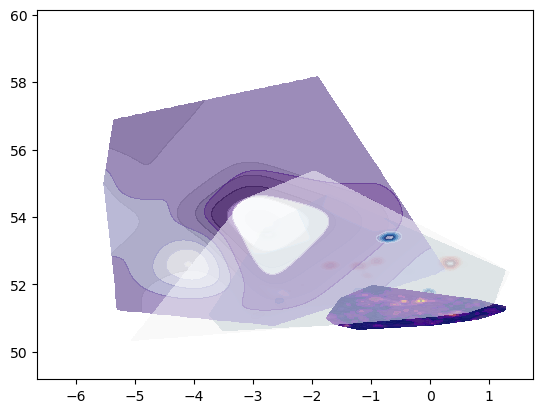

In [78]:
mapgeo = plotonmap(data=elenew,cmtypes= cmnew, levels=levelsnew,meteoEle=['precipitationIntensity','particulateMatter25','windDirection','dewPoint'])
mapgeo

In [62]:
mapgeo.save(f'./map/a_map.html')

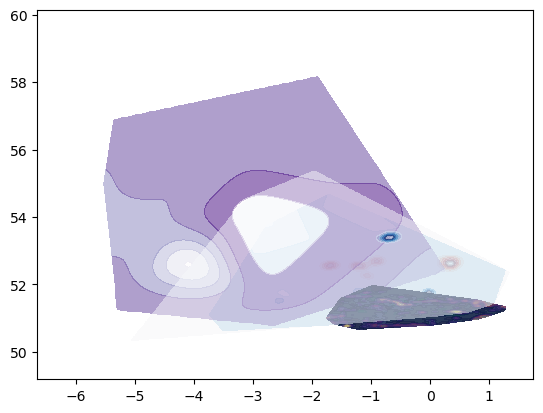

In [58]:
toplotnew  = ['wet_rain','wet_river','wet_tide','class','medianPrice','impact','risk','live_rain']

rainday = plotonmap(toplot = toplotnew, data=elenew,cmtypes= cmnew, levels=levelsnew,meteoEle=['precipitationIntensity'])
rainday

In [61]:
rainday.save(f'./map/rainday.html')